In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras import regularizers

In [ ]:
from google.colab import drive
import os

# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
from keras.preprocessing.image import load_img, img_to_array, array_to_img, save_img
import numpy as np

# Atur path dataset
source_dir = '/content/drive/MyDrive/DATASET/Monkeypox Skin Image Dataset/'
target_dir = '/content/drive/MyDrive/DATASET/PERCOBAAN 5/[85%:15%] 0.35 Dataset Augmentasi'
os.makedirs(target_dir, exist_ok=True)

# Jumlah target total citra per kelas setelah augmentasi
target_count=293  # Sesuaikan dengan jumlah kelas terbanyak (Normal)

# Konfigurasi augmentasi
augmentor = ImageDataGenerator(
    rotation_range=20,
    zoom_range=0.2,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Fungsi augmentasi
def augment_class(class_name):
    class_path = os.path.join(source_dir, class_name)
    images = os.listdir(class_path)
    current_count = len(images)
    augment_needed = target_count - current_count

    print(f'[{class_name}] Data awal: {current_count}, Augmentasi diperlukan: {augment_needed}')

    save_class_dir = os.path.join(target_dir, class_name)
    os.makedirs(save_class_dir, exist_ok=True)

    img_index = 0
    while augment_needed > 0:
        img_name = images[img_index % current_count]
        img_path = os.path.join(class_path, img_name)
        img = load_img(img_path, target_size=(224, 224))  # Resize sesuai model
        x = img_to_array(img)
        x = x.reshape((1,) + x.shape)

        prefix = img_name.split('.')[0]
        i = 0
        for batch in augmentor.flow(x, batch_size=1):
            new_filename = f'{prefix}_aug{i}.jpg'
            save_path = os.path.join(save_class_dir, new_filename)
            save_img(save_path, array_to_img(batch[0]))
            i += 1
            augment_needed -= 1
            if augment_needed <= 0:
                break
        img_index += 1

# Jalankan untuk dua kelas minoritas
augment_class('Chickenpox')
augment_class('Measles')
augment_class('Monkeypox')

[Chickenpox] Data awal: 107, Augmentasi diperlukan: 186
[Measles] Data awal: 91, Augmentasi diperlukan: 202
[Monkeypox] Data awal: 279, Augmentasi diperlukan: 14


In [ ]:
import os
import shutil
import random

# Path asal data
original_dataset_dir = '/content/drive/MyDrive/DATASET/Monkeypox Skin Image Dataset/'
augmented_dataset_dir = '/content/drive/MyDrive/DATASET/PERCOBAAN 5/[85%:15%] 0.35 Dataset Augmentasi'
merged_dataset_dir = '/content/drive/MyDrive/DATASET/PERCOBAAN 5/[85%:15%] 0.35 Merged Dataset'

# Folder baru hasil pembagian train/test
train_dir = '/content/drive/MyDrive/DATASET/PERCOBAAN 5/[85%:15%] 0.35 Final Dataset/train'
test_dir = '/content/drive/MyDrive/DATASET/PERCOBAAN 5/[85%:15%] 0.35 Final Dataset/test'

# Proporsi split
split_ratio = 0.85

# Gabungkan data asli dan hasil augmentasi
def merge_original_and_augmented(original_dir, augmented_dir, output_dir):
    os.makedirs(output_dir, exist_ok=True)
    class_names = os.listdir(original_dir)

    for class_name in class_names:
        src_class_dir = os.path.join(original_dir, class_name)
        aug_class_dir = os.path.join(augmented_dir, class_name)
        target_class_dir = os.path.join(output_dir, class_name)

        os.makedirs(target_class_dir, exist_ok=True)

        # Salin data asli
        for fname in os.listdir(src_class_dir):
            shutil.copy(os.path.join(src_class_dir, fname), os.path.join(target_class_dir, fname))

        # Salin data augmentasi jika ada
        if os.path.exists(aug_class_dir):
            for fname in os.listdir(aug_class_dir):
                shutil.copy(os.path.join(aug_class_dir, fname), os.path.join(target_class_dir, fname))

# Split menjadi train dan test
def split_train_test(input_dir, train_output, test_output, split_ratio=0.85):
    os.makedirs(train_output, exist_ok=True)
    os.makedirs(test_output, exist_ok=True)

    for class_name in os.listdir(input_dir):
        class_dir = os.path.join(input_dir, class_name)
        images = os.listdir(class_dir)
        random.shuffle(images)

        split_index = int(len(images) * split_ratio)
        train_images = images[:split_index]
        test_images = images[split_index:]

        train_class_dir = os.path.join(train_output, class_name)
        test_class_dir = os.path.join(test_output, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        for fname in train_images:
            shutil.copy(os.path.join(class_dir, fname), os.path.join(train_class_dir, fname))
        for fname in test_images:
            shutil.copy(os.path.join(class_dir, fname), os.path.join(test_class_dir, fname))

# Jalankan proses
merge_original_and_augmented(original_dataset_dir, augmented_dataset_dir, merged_dataset_dir)
split_train_test(merged_dataset_dir, train_dir, test_dir, split_ratio)

# Tampilkan isi direktori akhir
{
    "train_classes": {cls: len(os.listdir(os.path.join(train_dir, cls))) for cls in os.listdir(train_dir)},
    "test_classes": {cls: len(os.listdir(os.path.join(test_dir, cls))) for cls in os.listdir(test_dir)}
}

{'train_classes': {'Monkeypox': 249,
  'Normal': 249,
  'Chickenpox': 249,
  'Measles': 249},
 'test_classes': {'Monkeypox': 44,
  'Normal': 44,
  'Chickenpox': 44,
  'Measles': 44}}

In [ ]:
import os
from collections import defaultdict

def count_images_per_class(merged_dataset_dir):
    class_counts = defaultdict(int)
    for class_name in os.listdir(merged_dataset_dir):
        class_dir = os.path.join(merged_dataset_dir, class_name)
        if os.path.isdir(class_dir):
            count = len(os.listdir(class_dir))
            class_counts[class_name] = count
    return class_counts

# Hitung jumlah per kelas
train_counts = count_images_per_class(train_dir)
test_counts = count_images_per_class(test_dir)

# Tampilkan tabel
print(f"{'Kelas':<20}{'Training':<10}{'Testing':<10}{'Total':<10}")
print("="*50)
for class_name in sorted(train_counts.keys()):
    train_num = train_counts[class_name]
    test_num = test_counts.get(class_name, 0)
    total = train_num + test_num
    print(f"{class_name:<20}{train_num:<10}{test_num:<10}{total:<10}")

Kelas               Training  Testing   Total     
Chickenpox          249       44        293       
Measles             249       44        293       
Monkeypox           249       44        293       
Normal              249       44        293       


In [ ]:
# Path ke dataset final
train_dir = '/content/drive/MyDrive/DATASET/PERCOBAAN 4/[85:15] 0.35 Final Dataset/train'
test_dir = '/content/drive/MyDrive/DATASET/PERCOBAAN 4/[85:15] 0.35 Final Dataset/test'

# ImageDataGenerator untuk normalisasi data
datagen = ImageDataGenerator(rescale=1./255)

# Load data training dan testing
train_data = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False  # agar label tetap sinkron
)

test_data = datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)

Found 996 images belonging to 4 classes.
Found 176 images belonging to 4 classes.


In [ ]:
import tensorflow as tf

# Buat model CNN dengan tf.keras.layers
inp = tf.keras.layers.Input(shape=(224, 224, 3))
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='valid')(inp)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', padding='valid')(x)
x = tf.keras.layers.MaxPooling2D((2, 2))(x)
x = tf.keras.layers.Flatten()(x)
feat = tf.keras.layers.Dense(512, activation='relu', name='feature_layer', kernel_regularizer=regularizers.l2(0.001))(x)
drop = tf.keras.layers.Dropout(0.35)(feat)
out = tf.keras.layers.Dense(4, activation='softmax')(drop)  # 4 kelas

cnn = tf.keras.Model(inputs=inp, outputs=out)

# Optimizer
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
# Compile Model
cnn.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 10, 10, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ feature_layer (Dense)           │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,124,740 (30.99 MB)

 Trainable params: 8,124,740 (30.99 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = cnn.fit(
    train_data,
    validation_data=test_data,
    epochs=50,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 251s 7s/step - accuracy: 0.2163 - loss: 2.3337 - val_accuracy: 0.2500 - val_loss: 2.1000
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 190s 5s/step - accuracy: 0.1936 - loss: 2.0631 - val_accuracy: 0.2500 - val_loss: 1.8710
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.1889 - loss: 1.9048 - val_accuracy: 0.2500 - val_loss: 1.7556
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 168s 5s/step - accuracy: 0.3334 - loss: 1.7528 - val_accuracy: 0.6080 - val_loss: 1.4877
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.4863 - loss: 1.5845 - val_accuracy: 0.6250 - val_loss: 1.3868
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 175s 6s/step - accuracy: 0.6084 - loss: 1.4211 - val_accuracy: 0.5739 - val_loss: 1.4626
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 164s 5s/step - accuracy: 0.4901 - loss: 1.5723 - val_accuracy: 0.7102 - val_loss: 1.0993
Epoch 8/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 167s 5s/step - accuracy: 0.6774 - loss: 1.1220 - val_accuracy: 0.6477 - v

In [ ]:
#Simpan Model
cnn.save('/content/drive/MyDrive/MODEL/model cnn [85:15] 0,35.h5')

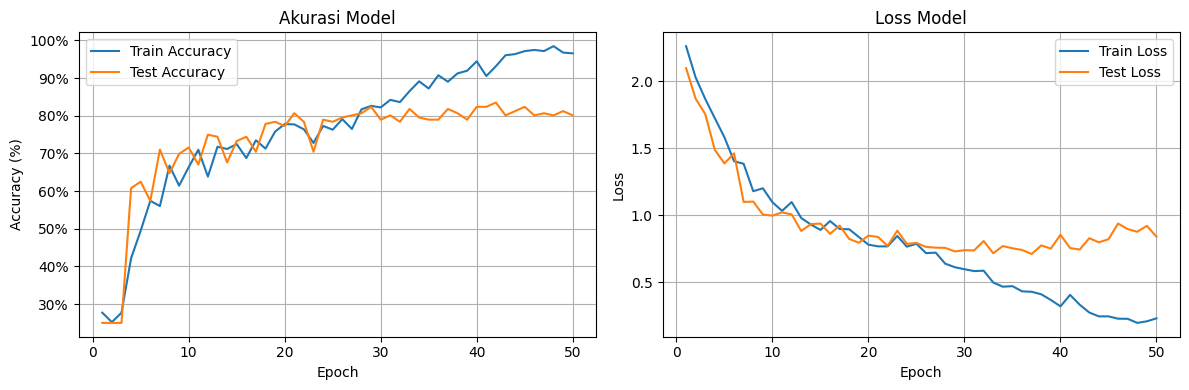

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Visualisasi akurasi & loss
plt.figure(figsize=(12, 4))

epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Test Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.plot(epochs, history.history['val_loss'], label='Test Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

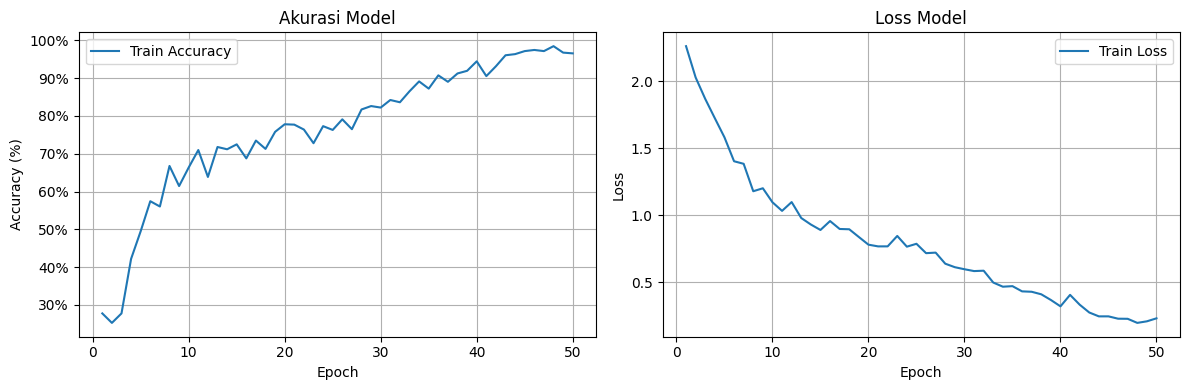

In [ ]:
# Visualisasi akurasi & loss
plt.figure(figsize=(12, 4))

epochs = range(1, len(history.history['accuracy']) + 1)

# Plot Akurasi
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Train Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.legend()
plt.grid(True)

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Train Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# Ambil nilai akhir dari akurasi dan loss pada data training
final_train_accuracy = history.history['accuracy'][-1]
final_train_loss = history.history['loss'][-1]

# Ambil nilai akhir dari akurasi dan loss pada data test
final_val_accuracy = history.history['val_accuracy'][-1]
final_val_loss = history.history['val_loss'][-1]

# Tampilkan hasil dalam bentuk persen untuk akurasi
print(f"Final Training Accuracy: {final_train_accuracy * 100:.2f}%")
print(f"Final Training Loss: {final_train_loss:.4f}")
print(f"Final Testing Accuracy: {final_val_accuracy * 100:.2f}%")
print(f"Final Testing Loss: {final_val_loss:.4f}")

Final Training Accuracy: 96.59%
Final Training Loss: 0.2289
Final Testing Accuracy: 80.11%
Final Testing Loss: 0.8391


In [ ]:
# Buat model ekstraksi fitur
feature_extractor = Model(inputs=cnn.input, outputs=cnn.get_layer('feature_layer').output)

In [ ]:
# --- Ekstraksi fitur
X_train_features = feature_extractor.predict(train_data, verbose=1)
X_test_features = feature_extractor.predict(test_data, verbose=1)

y_train = np.argmax(train_data.labels, axis=-1)
y_test = np.argmax(test_data.labels, axis=-1)

32/32 ━━━━━━━━━━━━━━━━━━━━ 50s 2s/step
6/6 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step


In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_features)
X_test_scaled = scaler.transform(X_test_features)

In [ ]:
# Label ground truth
y_train = train_data.classes
y_test = test_data.classes

In [ ]:
#Train SVM One Against One
from sklearn.multiclass import OneVsOneClassifier
from sklearn.svm import SVC

svm_model = OneVsOneClassifier(SVC(kernel='linear', C=0.1))
svm_model.fit(X_train_scaled, y_train)

OneVsOneClassifier(estimator=SVC(C=0.1, kernel='linear'))

=== Classification Report ===
              precision    recall  f1-score   support

  Chickenpox       0.86      0.86      0.86        44
     Measles       0.85      0.89      0.87        44
   Monkeypox       0.76      0.80      0.78        44
      Normal       0.90      0.82      0.86        44

    accuracy                           0.84       176
   macro avg       0.84      0.84      0.84       176
weighted avg       0.84      0.84      0.84       176

=== Confusion Matrix ===
[[38  1  4  1]
 [ 1 39  3  1]
 [ 3  4 35  2]
 [ 2  2  4 36]]
Akurasi model SVM: 0.8409
Akurasi (%): 84.09%


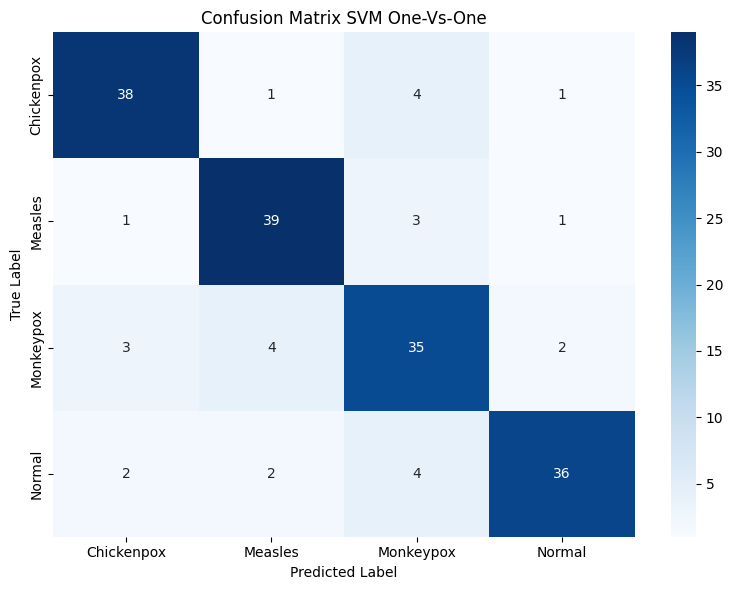

In [ ]:
# 9. Prediksi dan evaluasi
y_pred = svm_model.predict(X_test_scaled)

print("=== Classification Report ===")
print(classification_report(y_test, y_pred, target_names=list(train_data.class_indices.keys())))

print("=== Confusion Matrix ===")
print(confusion_matrix(y_test, y_pred))

from sklearn.metrics import accuracy_score

accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi model SVM: {accuracy:.4f}")
print(f"Akurasi (%): {accuracy * 100:.2f}%")

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Buat confusion matrix
cm = confusion_matrix(y_test, y_pred)
labels = list(train_data.class_indices.keys())  # ['Chickenpox', 'Measles', 'Monkeypox', 'Normal']

# Plot dengan seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)

plt.title('Confusion Matrix SVM One-Vs-One')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Train SVM One Against All
svm_model_ova = OneVsRestClassifier(SVC(kernel='linear', C=100))
svm_model_ova.fit(X_train_scaled, y_train)

OneVsRestClassifier(estimator=SVC(C=100, kernel='linear'))

Akurasi Model: 82.39%


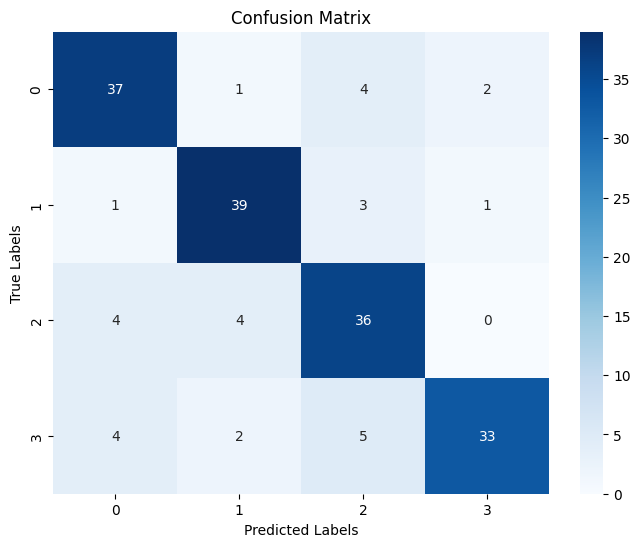

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.84      0.82        44
           1       0.85      0.89      0.87        44
           2       0.75      0.82      0.78        44
           3       0.92      0.75      0.82        44

    accuracy                           0.82       176
   macro avg       0.83      0.82      0.82       176
weighted avg       0.83      0.82      0.82       176



In [ ]:
# Prediksi data test
y_pred_ova = svm_model_ova.predict(X_test_scaled)

# Hitung akurasi
accuracy = accuracy_score(y_test, y_pred_ova)
print(f'Akurasi Model: {accuracy * 100:.2f}%')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_ova)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=svm_model.classes_, yticklabels=svm_model.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print('Classification Report:')
print(classification_report(y_test, y_pred_ova))